In [3]:
import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from keras.preprocessing import image                  
from tqdm import tqdm

from vgg16 import VGG16
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn import metrics

from scipy import interp
from itertools import cycle

import random
random.seed(8675309)

In [4]:
def getNamesList(min_faces_per_person):
    lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person)
    names_list = []
    for name in lfw_people.target_names:
        a = name.split(' ')
        newA = []
        for i in range(0,len(a)):
            newA.append(a[i])
            if (i != len(a)-1):
                newA.append('_')
        new_name = ''
        for i in range(0,len(newA)):
            new_name += newA[i]
        names_list.append(new_name)
    return names_list

In [5]:
def getLabels(train_data):
    human_files_train_labels = np.zeros([train_data.shape[0]], dtype=int)
    for i in range (0,train_data.shape[0]):
        #print(train_data[i])
        label = train_data[i].split('/')[1]
        human_files_train_labels[i] = human_files_dictionary[label]
    return human_files_train_labels

In [6]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [8]:
def convert_to_categorical(labels):
    y = np.zeros([labels.shape[0],len(human_files_names)])
    for i in range(0,labels.shape[0]):
        y[i][labels[i]] = 1
    return y

In [9]:
def getPersonName(index):
    for key in human_files_dictionary.keys():
         if (index == human_files_dictionary[key]):
                return key

In [10]:
history = AccuracyHistory()

In [11]:
min_faces_per_person = 70
names_list = getNamesList(min_faces_per_person)

In [12]:
human_files_data = []
human_files_names = []
for i in range (0,len(names_list)):
    #human_files = np.array(glob('lfw/'+names_list[i]+'/*'))
    human_files_data.append(glob('lfw/'+names_list[i]+'/*'))
    human_files_names.append('lfw/'+names_list[i])
human_files = []
for i in range(0,len(names_list)):
    data = human_files_data[i]
    for j in range(0,len(data)):
        human_files.append(data[j])
human_files = np.asarray(human_files)
random.shuffle(human_files)

In [15]:
#human_files = np.array(glob("lfw/*/*"))
#random.shuffle(human_files)
#human_files_names = np.array(glob("lfw/*"))

In [16]:
human_files_dictionary = dict()
for i in range(0,len(human_files_names)):
    human_files_dictionary.update({human_files_names[i].split('/')[1] : i})

In [17]:
train_divider = 0.5
test_divider = 0.3
train_limit = np.rint(train_divider * human_files.shape[0]).astype(int)
test_limit = np.rint(test_divider * human_files.shape[0]).astype(int)
#print(train_limit)
#print(test_limit)
human_files_train = human_files[ : train_limit]
human_files_test = human_files[train_limit : test_limit+train_limit]
human_files_valid = human_files[test_limit+train_limit : ]

In [18]:
human_files_train_labels = getLabels(human_files_train)
human_files_test_labels = getLabels(human_files_test)
human_files_valid_labels = getLabels(human_files_valid)

In [19]:
human_files_valid_labels

array([3, 0, 1, 5, 2, 3, 3, 6, 3, 4, 3, 3, 3, 3, 1, 2, 0, 4, 3, 3, 3, 1, 4,
       6, 5, 1, 1, 3, 6, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 0, 1, 3, 3, 2, 0, 3,
       3, 2, 3, 3, 0, 3, 3, 1, 3, 1, 5, 4, 3, 5, 0, 6, 6, 6, 3, 2, 4, 6, 3,
       1, 3, 0, 6, 0, 1, 6, 3, 3, 3, 3, 1, 6, 4, 4, 1, 1, 3, 3, 3, 3, 2, 1,
       3, 6, 0, 1, 3, 4, 6, 1, 6, 4, 2, 4, 3, 6, 1, 3, 2, 3, 6, 3, 1, 1, 1,
       3, 2, 3, 3, 3, 4, 1, 3, 3, 3, 4, 3, 3, 3, 1, 2, 3, 2, 3, 1, 3, 3, 1,
       3, 1, 6, 5, 1, 3, 0, 5, 1, 1, 6, 2, 6, 1, 6, 3, 3, 3, 6, 3, 3, 3, 4,
       3, 6, 5, 3, 3, 3, 4, 6, 3, 0, 3, 6, 3, 3, 1, 3, 3, 3, 6, 3, 3, 3, 6,
       2, 1, 3, 2, 5, 1, 1, 5, 1, 3, 1, 4, 6, 4, 3, 2, 1, 1, 1, 3, 3, 0, 3,
       1, 4, 3, 6, 3, 3, 3, 3, 0, 4, 2, 3, 4, 5, 6, 2, 3, 0, 0, 5, 3, 1, 5,
       2, 3, 1, 3, 5, 3, 3, 3, 3, 2, 1, 3, 6, 3, 3, 1, 4, 3, 4, 0, 1, 3, 3,
       3, 4, 4, 3, 3])

In [20]:
train_tensors = paths_to_tensor(human_files_train).astype('float32')/255
test_tensors = paths_to_tensor(human_files_test).astype('float32')/255
valid_tensors = paths_to_tensor(human_files_valid).astype('float32')/255

100%|██████████| 258/258 [00:06<00:00, 38.54it/s]


In [21]:
y_train = convert_to_categorical(human_files_train_labels)
y_test = convert_to_categorical(human_files_test_labels)
y_valid = convert_to_categorical(human_files_valid_labels)

In [22]:
image_input = Input(shape=(224, 224, 3))
model = VGG16(include_top=True,input_tensor=image_input,weights='imagenet')
model.summary()

 11214848/553467096 [..............................] - ETA: 1:06:14

KeyboardInterrupt: 

In [19]:
output_size = len(human_files_names)
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
#out = Dense(1, activation='softmax', name='output')(x)
out = Dense(output_size, activation='softmax', name='output')(x)
vgg_model = Model(image_input, out)
#vgg_model.summary()

In [20]:
output_size = len(human_files_names)
last_layer = model.get_layer('fc2').output
out = Dense(output_size, activation='softmax', name='output')(last_layer)
normal_model = Model(image_input, out)
#normal_model.summary()

In [21]:
for layer in vgg_model.layers[:-3]:
    layer.trainable = False

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:
#vgg_model.compile(loss=keras.losses.mean_squared_error,
#              optimizer=keras.optimizers.SGD(lr=0.1),
#              metrics=['accuracy'])

In [23]:
vgg_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [24]:
normal_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [25]:
#vgg_model.fit(train_tensors, human_files_train_labels,
#          batch_size=100,
#          epochs=50,
#          verbose=1,
#          validation_data=(valid_tensors, human_files_valid_labels),
#          callbacks=[history])

In [26]:
hist = vgg_model.fit(train_tensors, y_train,
          batch_size=15,
          epochs=50,
          verbose=1,
          validation_data=(valid_tensors, y_valid),
          callbacks=[history])

Train on 644 samples, validate on 258 samples
Epoch 1/50
644/644 [==============================] - 22s - loss: 1.8983 - acc: 0.3975 - val_loss: 1.8079 - val_acc: 0.1163
Epoch 2/50
644/644 [==============================] - 17s - loss: 1.5813 - acc: 0.4379 - val_loss: 1.6783 - val_acc: 0.3295
Epoch 3/50
644/644 [==============================] - 17s - loss: 1.4840 - acc: 0.4363 - val_loss: 1.5170 - val_acc: 0.3915
Epoch 4/50
644/644 [==============================] - 17s - loss: 1.3441 - acc: 0.5093 - val_loss: 1.5349 - val_acc: 0.3411
Epoch 5/50
644/644 [==============================] - 17s - loss: 1.2318 - acc: 0.5668 - val_loss: 1.4335 - val_acc: 0.3953
Epoch 6/50
644/644 [==============================] - 17s - loss: 1.1577 - acc: 0.5807 - val_loss: 1.5588 - val_acc: 0.3450
Epoch 7/50
644/644 [==============================] - 17s - loss: 1.1575 - acc: 0.5854 - val_loss: 1.5969 - val_acc: 0.3605
Epoch 8/50
644/644 [==============================] - 17s - loss: 0.9812 - acc: 0.6382

In [27]:
(loss, accuracy) = vgg_model.evaluate(test_tensors, y_test, batch_size=10, verbose=1)
print("[VGG16 MODEL TESTING RESULTS (WITH FINE-TUNING)] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

386/386 [==============================] - 10s    
[VGG16 MODEL TESTING RESULTS (WITH FINE-TUNING)] loss=0.4021, accuracy: 88.0829%


In [28]:
(loss, accuracy) = normal_model.evaluate(test_tensors, y_test, batch_size=10, verbose=1)
print("[VGG16 MODEL TESTING RESULTS (WITHOUT FINE-TUNING)] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

386/386 [==============================] - 9s     
[VGG16 MODEL TESTING RESULTS (WITHOUT FINE-TUNING)] loss=2.5529, accuracy: 8.2902%


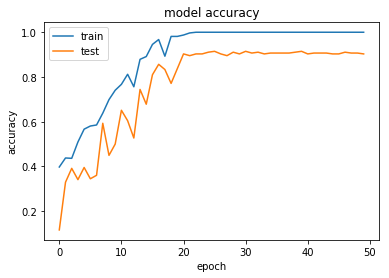

In [29]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

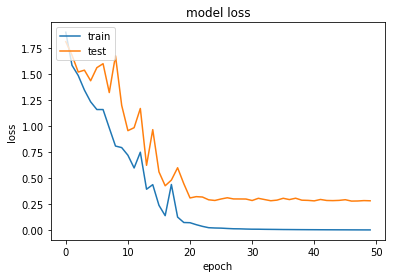

In [30]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
prediction = vgg_model.predict(test_tensors)
prediction = np.argmax(prediction,axis=1)
y_pred = convert_to_categorical(prediction)

In [32]:
y_compare = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_compare,prediction)
print(score)

0.880829015544


In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
line_width = 3

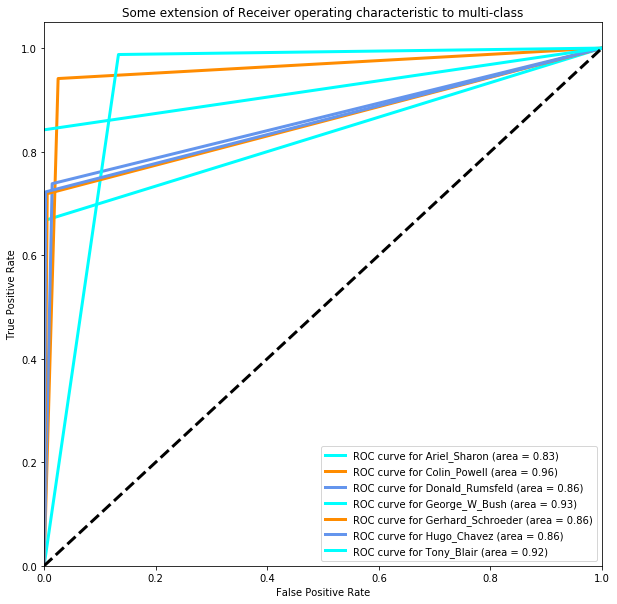

In [37]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(output_size)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(output_size):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= output_size

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(output_size), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve for '+getPersonName(i)+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()